In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
import pymc3 as pm
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [4]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

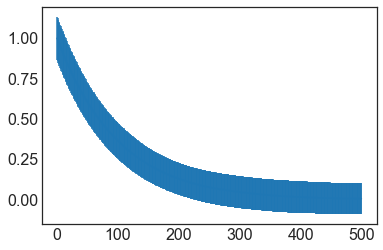

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

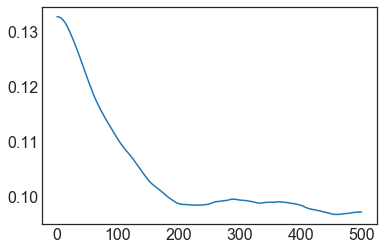

In [6]:
plt.plot(t,acf_std)

In [7]:
acf_all[0].size

500

In [8]:
mod = ExponentialModel()
result_array = None
for i,y in enumerate(acf_all):
    print("***** Iteration ",i," *****")
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[0,0],
                            out.values['amplitude'],
                            out.covar[1,1],
                            out.covar[0,1]])
        print(out.fit_report(min_correl=0.25))
        
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = None
        print('fit did not work weights')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            out2.covar[0,0],
                            out2.values['amplitude'],
                            out2.covar[1,1],
                            out.covar[0,1]])
        print(out2.fit_report(min_correl=0.25))
    
    if (fit_results is None) or (fit_std_results is None):
        continue
        
    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  0  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.37953197
    reduced chi-square = 7.6211e-04
    Akaike info crit   = -3587.71227
    Bayesian info crit = -3579.28305
[[Variables]]
    decay:      99.3941865 +/- 0.96000784 (0.97%) (init = 100)
    amplitude:  0.80861570 +/- 0.00548762 (0.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 36.8918773
    reduced chi-square = 0.07408007
    Akaike info crit   = -1299.30835
    Bayesian info crit = -1290.87913
[[Variables]]
    decay:      101.268683 +/- 1.05611196 (1.04%) (init = 100)
    amplitude:  0.79842691 +/- 0.0066952

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 0.55447745
    reduced chi-square = 0.00111341
    Akaike info crit   = -3398.16862
    Bayesian info crit = -3389.73941
[[Variables]]
    decay:      156.475374 +/- 1.60634746 (1.03%) (init = 100)
    amplitude:  0.75978277 +/- 0.00537198 (0.71%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.714

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 50.3363559
    reduced chi-square = 0.10107702
    Akaike info crit   = -1143.94025
    Bayesian info crit = -1135.51103
[[Variables]]
    decay:      161.689471 +/- 1.72138751 (1.06%) (init = 100)
    amplitude:  0.74111143 +/- 0.00617085 (0.83%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.76536101
    reduced chi-square = 0.00354490
    Akaike info crit   = -2819.12644
    Bayesian info crit = -2810.69723
[[Variables]]
    decay:      83.3662645 +/- 1.64373890 (1.97%) (init = 100)
    amplitude:  0.93036171 +/- 0.01288885 (1.39%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 180.780761
    reduced chi-square = 0.36301358
    Akaike info crit   = -504.661532
    Bayesian info crit = -496.232316
[[Variables]]
    decay:      81.6413099 +/- 1.79431261 (2.20%) (init = 100)
    amplitude:  0.94539242 +/- 0.01659610 (1.76%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.50154866
    reduced chi-square = 0.00100713
    Akaike info crit   = -3448.33138
    Bayesian info crit = -3439.90216
[[Variables]]
    decay:      80.4907448 +/- 0.93966440 (1.17%) (init = 100)
    amplitude:  0.85205701 +/- 0.00698830 (0.82%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 47.9633257
    reduced chi-square = 0.09631190
    Akaike info crit   = -1168.08571
    Bayesian info crit = -1159.65650
[[Variables]]
    decay:      83.5739191 +/- 1.06025852 (1.27%) (init = 100)
    amplitude:  0.83247490 +/- 0.00844368 (1.01%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 337.019991
    reduced chi-square = 0.67674697
    Akaike info crit   = -193.232924
    Bayesian info crit = -184.803708
[[Variables]]
    decay:      57.7177667 +/- 1.56684679 (2.71%) (init = 100)
    amplitude:  1.28134817 +/- 0.02715348 (2.12%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

***** Iteration  73  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.60322418
    reduced chi-square = 0.00121129
    Akaike info crit   = -3356.03724
    Bayesian info crit = -3347.60802
[[Variables]]
    decay:      63.8031480 +/- 0.82674294 (1.30%) (init = 100)
    amplitude:  0.94365481 +/- 0.008579

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 26.2461122
    reduced chi-square = 0.05270304
    Akaike info crit   = -1469.54511
    Bayesian info crit = -1461.11590
[[Variables]]
    decay:      102.294609 +/- 0.68064933 (0.67%) (init = 100)
    amplitude:  1.04983248 +/- 0.00561754 (0.54%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.723

***** Iteration  93  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.39705098
    reduced chi-square = 7.9729e-04
    Akaike info crit   = -3565.14934
    Bayesian info crit = -3556.72013
[[Variables]]
    decay:      75.6622806 +/- 0.76988914 (1.02%) (init = 100)
    amplitude:  0.89658441 +/- 0.006407

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 4.29210594
    reduced chi-square = 0.00861869
    Akaike info crit   = -2374.91530
    Bayesian info crit = -2366.48608
[[Variables]]
    decay:      119.202641 +/- 3.42836588 (2.88%) (init = 100)
    amplitude:  0.83946604 +/- 0.01691886 (2.02%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 424.994317
    reduced chi-square = 0.85340224
    Akaike info crit   = -77.2661509
    Bayesian info crit = -68.8369348
[[Variables]]
    decay:      133.158676 +/- 4.23607174 (3.18%) (init = 100)
    amplitude:  0.77627675 +/- 0.01972967 (2.54%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 3.97504808
    reduced chi-square = 0.00798202
    Akaike info crit   = -2413.28563
    Bayesian info crit = -2404.85641
[[Variables]]
    decay:      63.8342011 +/- 1.55722669 (2.44%) (init = 100)
    amplitude:  1.28670593 +/- 0.02201742 (1.71%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 393.387643
    reduced chi-square = 0.78993503
    Akaike info crit   = -115.906302
    Bayesian info crit = -107.477086
[[Variables]]
    decay:      61.5729507 +/- 1.69214138 (2.75%) (init = 100)
    amplitude:  1.31545634 +/- 0.02837307 (2.16%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.02010839
    reduced chi-square = 0.00204841
    Akaike info crit   = -3093.34961
    Bayesian info crit = -3084.92039
[[Variables]]
    decay:      84.9592281 +/- 0.93063940 (1.10%) (init = 100)
    amplitude:  1.26112979 +/- 0.00970830 (0.77%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 97.3749908
    reduced chi-square = 0.19553211
    Akaike info crit   = -814.019345
    Bayesian info crit = -805.590128
[[Variables]]
    decay:      82.8584593 +/- 0.97811351 (1.18%) (init = 100)
    amplitude:  1.28095891 +/- 0.01208572 (0.94%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 428.243165
    reduced chi-square = 0.85992603
    Akaike info crit   = -73.4584607
    Bayesian info crit = -65.0292445
[[Variables]]
    decay:      113.881962 +/- 3.56359173 (3.13%) (init = 100)
    amplitude:  0.85294409 +/- 0.02145697 (2.52%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.727

***** Iteration  173  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.55621688
    reduced chi-square = 0.00111690
    Akaike info crit   = -3396.60255
    Bayesian info crit = -3388.17333
[[Variables]]
    decay:      119.507100 +/- 1.02081355 (0.85%) (init = 100)
    amplitude:  1.01645609 +/- 0.00608

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 250.834018
    reduced chi-square = 0.50368277
    Akaike info crit   = -340.908329
    Bayesian info crit = -332.479113
[[Variables]]
    decay:      127.690663 +/- 2.77336342 (2.17%) (init = 100)
    amplitude:  0.89010083 +/- 0.01548300 (1.74%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.732

***** Iteration  192  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.04943408
    reduced chi-square = 0.00411533
    Akaike info crit   = -2744.52220
    Bayesian info crit = -2736.09298
[[Variables]]
    decay:      147.604880 +/- 2.30334880 (1.56%) (init = 100)
    amplitude:  0.98054497 +/- 0.01059

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.09049927
    reduced chi-square = 0.00218976
    Akaike info crit   = -3059.98623
    Bayesian info crit = -3051.55701
[[Variables]]
    decay:      53.2195852 +/- 1.04741681 (1.97%) (init = 100)
    amplitude:  0.91342509 +/- 0.01259104 (1.38%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.700

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 99.3402117
    reduced chi-square = 0.19947834
    Akaike info crit   = -804.028829
    Bayesian info crit = -795.599612
[[Variables]]
    decay:      51.0336803 +/- 1.10961587 (2.17%) (init = 100)
    amplitude:  0.93454635 +/- 0.01570970 (1.68%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 50.1916680
    reduced chi-square = 0.10078648
    Akaike info crit   = -1145.37953
    Bayesian info crit = -1136.95031
[[Variables]]
    decay:      190.415040 +/- 2.18476605 (1.15%) (init = 100)
    amplitude:  0.65741983 +/- 0.00571394 (0.87%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.757

***** Iteration  232  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.85390990
    reduced chi-square = 0.00171468
    Akaike info crit   = -3182.26884
    Bayesian info crit = -3173.83963
[[Variables]]
    decay:      90.9252590 +/- 1.17257286 (1.29%) (init = 100)
    amplitude:  0.94814052 +/- 0.00859

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.03545736
    reduced chi-square = 0.00207923
    Akaike info crit   = -3085.88244
    Bayesian info crit = -3077.45322
[[Variables]]
    decay:      177.970950 +/- 1.79607034 (1.01%) (init = 100)
    amplitude:  1.01746127 +/- 0.00695177 (0.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.719

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 92.3629247
    reduced chi-square = 0.18546772
    Akaike info crit   = -840.441224
    Bayesian info crit = -832.012008
[[Variables]]
    decay:      184.488992 +/- 1.92199401 (1.04%) (init = 100)
    amplitude:  0.98892468 +/- 0.00786200 (0.80%) (init = 1)
[[Cor

***** Iteration  272  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.09850362
    reduced chi-square = 0.00220583
    Akaike info crit   = -3056.32959
    Bayesian info crit = -3047.90038
[[Variables]]
    decay:      111.426351 +/- 1.37411458 (1.23%) (init = 100)
    amplitude:  1.02122514 +/- 0.00883729 (0.87%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 113.104426
    reduced chi-square = 0.22711732
    Akaike info crit   = -739.148290
    Bayesian info crit = -730.719074
[[Variables]]
    decay:      112.045377 +/- 1.52072649 (1.36%) (init = 100)
    amplitude:  1.01907297 +/- 0.01112

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 3.21931320
    reduced chi-square = 0.00646448
    Akaike info crit   = -2518.72003
    Bayesian info crit = -2510.29081
[[Variables]]
    decay:      62.2043809 +/- 1.62444684 (2.61%) (init = 100)
    amplitude:  1.09553291 +/- 0.02006402 (1.83%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.701

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 319.159900
    reduced chi-square = 0.64088333
    Akaike info crit   = -220.457933
    Bayesian info crit = -212.028717
[[Variables]]
    decay:      59.8138965 +/- 1.76661570 (2.95%) (init = 100)
    amplitude:  1.12198015 +/- 0.02594049 (2.31%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.95884627
    reduced chi-square = 0.00393343
    Akaike info crit   = -2767.12622
    Bayesian info crit = -2758.69700
[[Variables]]
    decay:      135.349420 +/- 2.41503180 (1.78%) (init = 100)
    amplitude:  0.86636469 +/- 0.01077362 (1.24%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.709

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 190.054451
    reduced chi-square = 0.38163544
    Akaike info crit   = -479.648741
    Bayesian info crit = -471.219524
[[Variables]]
    decay:      144.414903 +/- 2.79275275 (1.93%) (init = 100)
    amplitude:  0.82569194 +/- 0.01266821 (1.53%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 34.3219959
    reduced chi-square = 0.06891967
    Akaike info crit   = -1335.41084
    Bayesian info crit = -1326.98162
[[Variables]]
    decay:      145.974126 +/- 0.82019882 (0.56%) (init = 100)
    amplitude:  1.20266157 +/- 0.00535487 (0.45%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.739

***** Iteration  333  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 2.37041120
    reduced chi-square = 0.00475986
    Akaike info crit   = -2671.77233
    Bayesian info crit = -2663.34311
[[Variables]]
    decay:      126.065392 +/- 1.88472207 (1.50%) (init = 100)
    amplitude:  1.17154573 +/- 0.01224

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 135.377499
    reduced chi-square = 0.27184237
    Akaike info crit   = -649.270465
    Bayesian info crit = -640.841249
[[Variables]]
    decay:      68.2937740 +/- 1.32985674 (1.95%) (init = 100)
    amplitude:  1.02440422 +/- 0.01576945 (1.54%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.710

***** Iteration  353  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 2.49663900
    reduced chi-square = 0.00501333
    Akaike info crit   = -2645.83134
    Bayesian info crit = -2637.40212
[[Variables]]
    decay:      122.510395 +/- 1.93112768 (1.58%) (init = 100)
    amplitude:  1.15426608 +/- 0.01273

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 399.219891
    reduced chi-square = 0.80164637
    Akaike info crit   = -108.547864
    Bayesian info crit = -100.118647
[[Variables]]
    decay:      57.8944414 +/- 2.32631644 (4.02%) (init = 100)
    amplitude:  0.94055905 +/- 0.02950513 (3.14%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

***** Iteration  372  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 5.88921361
    reduced chi-square = 0.01182573
    Akaike info crit   = -2216.74281
    Bayesian info crit = -2208.31360
[[Variables]]
    decay:      148.624684 +/- 2.93680858 (1.98%) (init = 100)
    amplitude:  1.30926012 +/- 0.01790

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.24270757
    reduced chi-square = 4.8736e-04
    Akaike info crit   = -3811.25305
    Bayesian info crit = -3802.82383
[[Variables]]
    decay:      130.223575 +/- 0.95390924 (0.73%) (init = 100)
    amplitude:  0.75466083 +/- 0.00386019 (0.51%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 20.1554939
    reduced chi-square = 0.04047288
    Akaike info crit   = -1601.56560
    Bayesian info crit = -1593.13638
[[Variables]]
    decay:      131.908501 +/- 0.95173183 (0.72%) (init = 100)
    amplitude:  0.74861600 +/- 0.00431687 (0.58%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.06162698
    reduced chi-square = 0.00413981
    Akaike info crit   = -2741.55632
    Bayesian info crit = -2733.12710
[[Variables]]
    decay:      124.098062 +/- 2.88895407 (2.33%) (init = 100)
    amplitude:  0.70624575 +/- 0.01150606 (1.63%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.707

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 186.852737
    reduced chi-square = 0.37520630
    Akaike info crit   = -488.143648
    Bayesian info crit = -479.714432
[[Variables]]
    decay:      138.246655 +/- 3.40107918 (2.46%) (init = 100)
    amplitude:  0.65507621 +/- 0.01283708 (1.96%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.41049927
    reduced chi-square = 0.00484036
    Akaike info crit   = -2663.38710
    Bayesian info crit = -2654.95789
[[Variables]]
    decay:      78.5034168 +/- 1.43330067 (1.83%) (init = 100)
    amplitude:  1.20896270 +/- 0.01550863 (1.28%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 251.658392
    reduced chi-square = 0.50533814
    Akaike info crit   = -339.267759
    Bayesian info crit = -330.838543
[[Variables]]
    decay:      77.3367961 +/- 1.60193003 (2.07%) (init = 100)
    amplitude:  1.22093292 +/- 0.02014624 (1.65%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.67480584
    reduced chi-square = 0.00135503
    Akaike info crit   = -3299.96919
    Bayesian info crit = -3291.53997
[[Variables]]
    decay:      102.116979 +/- 0.70840733 (0.69%) (init = 100)
    amplitude:  1.48206494 +/- 0.00722238 (0.49%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 67.0725098
    reduced chi-square = 0.13468375
    Akaike info crit   = -1000.41691
    Bayesian info crit = -991.987698
[[Variables]]
    decay:      101.315843 +/- 0.76301475 (0.75%) (init = 100)
    amplitude:  1.49051610 +/- 0.00902522 (0.61%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 448.601984
    reduced chi-square = 0.90080720
    Akaike info crit   = -50.2360271
    Bayesian info crit = -41.8068109
[[Variables]]
    decay:      75.9289788 +/- 2.42460447 (3.19%) (init = 100)
    amplitude:  1.06905179 +/- 0.02715459 (2.54%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.713

***** Iteration  474  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.80195802
    reduced chi-square = 0.00361839
    Akaike info crit   = -2808.86712
    Bayesian info crit = -2800.43790
[[Variables]]
    decay:      111.168179 +/- 2.26067007 (2.03%) (init = 100)
    amplitude:  0.79397460 +/- 0.01133

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 0.67284928
    reduced chi-square = 0.00135110
    Akaike info crit   = -3301.42101
    Bayesian info crit = -3292.99179
[[Variables]]
    decay:      96.9966015 +/- 1.05816216 (1.09%) (init = 100)
    amplitude:  0.96440998 +/- 0.00739349 (0.77%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 69.5978961
    reduced chi-square = 0.13975481
    Akaike info crit   = -981.936880
    Bayesian info crit = -973.507664
[[Variables]]
    decay:      97.2694078 +/- 1.18088917 (1.21%) (init = 100)
    amplitude:  0.96277529 +/- 0.00939221 (0.98%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.44300942
    reduced chi-square = 8.8958e-04
    Akaike info crit   = -3510.38617
    Bayesian info crit = -3501.95696
[[Variables]]
    decay:      94.4836560 +/- 0.89582244 (0.95%) (init = 100)
    amplitude:  0.91187316 +/- 0.00607595 (0.67%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 42.2103093
    reduced chi-square = 0.08475966
    Akaike info crit   = -1231.97181
    Bayesian info crit = -1223.54259
[[Variables]]
    decay:      97.2147608 +/- 0.99022433 (1.02%) (init = 100)
    amplitude:  0.89397672 +/- 0.00731638 (0.82%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 217.613962
    reduced chi-square = 0.43697583
    Akaike info crit   = -411.942712
    Bayesian info crit = -403.513495
[[Variables]]
    decay:      108.040027 +/- 1.86621785 (1.73%) (init = 100)
    amplitude:  1.13138731 +/- 0.01572076 (1.39%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.725

***** Iteration  536  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.94346002
    reduced chi-square = 0.00390253
    Akaike info crit   = -2771.06910
    Bayesian info crit = -2762.63988
[[Variables]]
    decay:      123.361499 +/- 2.05828970 (1.67%) (init = 100)
    amplitude:  0.95934313 +/- 0.01120

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.39814826
    reduced chi-square = 7.9949e-04
    Akaike info crit   = -3563.76947
    Bayesian info crit = -3555.34025
[[Variables]]
    decay:      78.4102467 +/- 0.65935785 (0.84%) (init = 100)
    amplitude:  1.06752498 +/- 0.00630631 (0.59%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 35.2023132
    reduced chi-square = 0.07068738
    Akaike info crit   = -1322.74815
    Bayesian info crit = -1314.31893
[[Variables]]
    decay:      76.7463545 +/- 0.67489042 (0.88%) (init = 100)
    amplitude:  1.08056291 +/- 0.00756464 (0.70%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 35.7938051
    reduced chi-square = 0.07187511
    Akaike info crit   = -1314.41663
    Bayesian info crit = -1305.98741
[[Variables]]
    decay:      87.6321149 +/- 0.74118256 (0.85%) (init = 100)
    amplitude:  1.05009648 +/- 0.00711482 (0.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.717

***** Iteration  576  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.49072503
    reduced chi-square = 0.00299342
    Akaike info crit   = -2903.67275
    Bayesian info crit = -2895.24353
[[Variables]]
    decay:      87.1327473 +/- 1.20027335 (1.38%) (init = 100)
    amplitude:  1.19754611 +/- 0.01159

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.92431901
    reduced chi-square = 0.00185606
    Akaike info crit   = -3142.65306
    Bayesian info crit = -3134.22384
[[Variables]]
    decay:      70.3847905 +/- 1.15864400 (1.65%) (init = 100)
    amplitude:  0.87610971 +/- 0.01012683 (1.16%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 93.2376847
    reduced chi-square = 0.18722427
    Akaike info crit   = -835.728058
    Bayesian info crit = -827.298842
[[Variables]]
    decay:      68.4881039 +/- 1.27037954 (1.85%) (init = 100)
    amplitude:  0.89111306 +/- 0.01306677 (1.47%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 9.14241398
    reduced chi-square = 0.01835826
    Akaike info crit   = -1996.84182
    Bayesian info crit = -1988.41260
[[Variables]]
    decay:      153.719013 +/- 4.81353362 (3.13%) (init = 100)
    amplitude:  1.01732742 +/- 0.02198419 (2.16%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.713

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 915.694999
    reduced chi-square = 1.83874498
    Akaike info crit   = 306.537620
    Bayesian info crit = 314.966836
[[Variables]]
    decay:      175.325208 +/- 6.21969029 (3.55%) (init = 100)
    amplitude:  0.92600700 +/- 0.02533844 (2.74%) (init = 1)
[[Corre

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 248.390411
    reduced chi-square = 0.49877593
    Akaike info crit   = -345.803176
    Bayesian info crit = -337.373960
[[Variables]]
    decay:      68.9023941 +/- 1.66817803 (2.42%) (init = 100)
    amplitude:  1.11041367 +/- 0.02126015 (1.91%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.710

***** Iteration  635  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.65104731
    reduced chi-square = 0.00130732
    Akaike info crit   = -3317.89053
    Bayesian info crit = -3309.46132
[[Variables]]
    decay:      82.8297189 +/- 1.02470679 (1.24%) (init = 100)
    amplitude:  0.90327097 +/- 0.00785

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.42201089
    reduced chi-square = 0.00285544
    Akaike info crit   = -2927.26805
    Bayesian info crit = -2918.83884
[[Variables]]
    decay:      57.5141642 +/- 1.25554687 (2.18%) (init = 100)
    amplitude:  0.90513947 +/- 0.01385048 (1.53%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.701

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 141.820664
    reduced chi-square = 0.28478045
    Akaike info crit   = -626.022383
    Bayesian info crit = -617.593166
[[Variables]]
    decay:      55.9063407 +/- 1.39923111 (2.50%) (init = 100)
    amplitude:  0.91880768 +/- 0.01790788 (1.95%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.03669720
    reduced chi-square = 0.00408975
    Akaike info crit   = -2747.63931
    Bayesian info crit = -2739.21009
[[Variables]]
    decay:      106.150854 +/- 1.61091882 (1.52%) (init = 100)
    amplitude:  1.15568952 +/- 0.01231582 (1.07%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 205.601613
    reduced chi-square = 0.41285464
    Akaike info crit   = -440.333860
    Bayesian info crit = -431.904644
[[Variables]]
    decay:      104.579390 +/- 1.72518526 (1.65%) (init = 100)
    amplitude:  1.17146523 +/- 0.01554159 (1.33%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 56.9488551
    reduced chi-square = 0.11435513
    Akaike info crit   = -1082.22726
    Bayesian info crit = -1073.79804
[[Variables]]
    decay:      115.187898 +/- 1.20765470 (1.05%) (init = 100)
    amplitude:  0.92311356 +/- 0.00777846 (0.84%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.728

***** Iteration  690  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.26336164
    reduced chi-square = 0.00253687
    Akaike info crit   = -2986.41598
    Bayesian info crit = -2977.98676
[[Variables]]
    decay:      61.5220765 +/- 1.36170654 (2.21%) (init = 100)
    amplitude:  0.81403901 +/- 0.01263

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 89.6157825
    reduced chi-square = 0.17995137
    Akaike info crit   = -855.538325
    Bayesian info crit = -847.109109
[[Variables]]
    decay:      75.4255576 +/- 1.16138837 (1.54%) (init = 100)
    amplitude:  0.99451521 +/- 0.01218046 (1.22%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.713

***** Iteration  711  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.78211037
    reduced chi-square = 0.00157050
    Akaike info crit   = -3226.18375
    Bayesian info crit = -3217.75454
[[Variables]]
    decay:      69.3819431 +/- 0.92909485 (1.34%) (init = 100)
    amplitude:  0.99786095 +/- 0.00937

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 186.024881
    reduced chi-square = 0.37354394
    Akaike info crit   = -490.363831
    Bayesian info crit = -481.934615
[[Variables]]
    decay:      77.3176690 +/- 1.48994742 (1.93%) (init = 100)
    amplitude:  1.12872057 +/- 0.01732172 (1.53%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.713

***** Iteration  730  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 7.23923596
    reduced chi-square = 0.01453662
    Akaike info crit   = -2113.54621
    Bayesian info crit = -2105.11700
[[Variables]]
    decay:      82.7451009 +/- 2.68443628 (3.24%) (init = 100)
    amplitude:  1.14926531 +/- 0.02619

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 500
    # variables        = 2
    chi-square         = 704.988121
    reduced chi-square = 1.41563880
    Akaike info crit   = 175.786427
    Bayesian info crit = 184.215643
[[Variables]]
    decay:      68.8872080 +/- 3.45154397 (5.01%) (init = 100)
    amplitude:  0.90377977 +/- 0.03582603 (3.96%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.710

***** Iteration  749  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 1.07801651
    reduced chi-square = 0.00216469
    Akaike info crit   = -3065.74266
    Bayesian info crit = -3057.31344
[[Variables]]
    decay:      88.3170342 +/- 1.10511782 (1.25%) (init = 100)
    amplitude:  1.11371617 +/- 0.0097934

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 144.592644
    reduced chi-square = 0.29034667
    Akaike info crit   = -616.343830
    Bayesian info crit = -607.914614
[[Variables]]
    decay:      75.4085902 +/- 1.34526714 (1.78%) (init = 100)
    amplitude:  1.09051142 +/- 0.01547361 (1.42%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.713

***** Iteration  770  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 4.28538352
    reduced chi-square = 0.00860519
    Akaike info crit   = -2375.69902
    Bayesian info crit = -2367.26981
[[Variables]]
    decay:      99.3395629 +/- 2.29220378 (2.31%) (init = 100)
    amplitude:  1.13767148 +/- 0.01844

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 61.6573511
    reduced chi-square = 0.12380994
    Akaike info crit   = -1042.50782
    Bayesian info crit = -1034.07860
[[Variables]]
    decay:      147.685877 +/- 1.52874648 (1.04%) (init = 100)
    amplitude:  0.87101271 +/- 0.00713623 (0.82%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.740

***** Iteration  790  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.76256372
    reduced chi-square = 0.00353928
    Akaike info crit   = -2819.91934
    Bayesian info crit = -2811.49013
[[Variables]]
    decay:      141.670021 +/- 2.08966061 (1.48%) (init = 100)
    amplitude:  0.97664552 +/- 0.01000

***** Iteration  810  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.11096502
    reduced chi-square = 0.00223085
    Akaike info crit   = -3050.68954
    Bayesian info crit = -3042.26032
[[Variables]]
    decay:      270.661753 +/- 2.49948469 (0.92%) (init = 100)
    amplitude:  1.10826859 +/- 0.00617686 (0.56%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.747

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 85.8887738
    reduced chi-square = 0.17246742
    Akaike info crit   = -876.777483
    Bayesian info crit = -868.348267
[[Variables]]
    decay:      278.463894 +/- 2.47826601 (0.89%) (init = 100)
    amplitude:  1.08649632 +/- 0.00641

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 168.812394
    reduced chi-square = 0.33898071
    Akaike info crit   = -538.910049
    Bayesian info crit = -530.480832
[[Variables]]
    decay:      103.486450 +/- 1.79994302 (1.74%) (init = 100)
    amplitude:  1.01229289 +/- 0.01416072 (1.40%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.723

***** Iteration  830  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 2.23174909
    reduced chi-square = 0.00448142
    Akaike info crit   = -2701.91124
    Bayesian info crit = -2693.48202
[[Variables]]
    decay:      60.5569435 +/- 1.44927956 (2.39%) (init = 100)
    amplitude:  1.00829463 +/- 0.01692

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.05713740
    reduced chi-square = 0.00212277
    Akaike info crit   = -3075.52171
    Bayesian info crit = -3067.09249
[[Variables]]
    decay:      68.6534248 +/- 1.15313146 (1.68%) (init = 100)
    amplitude:  0.92966902 +/- 0.01096137 (1.18%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 105.277994
    reduced chi-square = 0.21140160
    Akaike info crit   = -775.001841
    Bayesian info crit = -766.572625
[[Variables]]
    decay:      67.3073167 +/- 1.27145929 (1.89%) (init = 100)
    amplitude:  0.93943441 +/- 0.01401105 (1.49%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 434.622298
    reduced chi-square = 0.87273554
    Akaike info crit   = -66.0653629
    Bayesian info crit = -57.6361467
[[Variables]]
    decay:      71.2977059 +/- 2.45192709 (3.44%) (init = 100)
    amplitude:  1.01334443 +/- 0.02762685 (2.73%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.711

***** Iteration  869  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.59472695
    reduced chi-square = 0.00119423
    Akaike info crit   = -3363.13049
    Bayesian info crit = -3354.70128
[[Variables]]
    decay:      82.7941283 +/- 0.98450242 (1.19%) (init = 100)
    amplitude:  0.89839073 +/- 0.00750

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 500
    # variables        = 2
    chi-square         = 9.12758319
    reduced chi-square = 0.01832848
    Akaike info crit   = -1997.65357
    Bayesian info crit = -1989.22436
[[Variables]]
    decay:      60.8968994 +/- 3.04525013 (5.00%) (init = 100)
    amplitude:  0.97364540 +/- 0.03413067 (3.51%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.701

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 500
    # variables        = 2
    chi-square         = 923.655581
    reduced chi-square = 1.85473008
    Akaike info crit   = 310.865578
    Bayesian info crit = 319.294794
[[Variables]]
    decay:      58.3733287 +/- 3.33312209 (5.71%) (init = 100)
    amplitude:  1.00146841 +/- 0.04469674 (4.46%) (init = 1)
[[Corre

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 500
    # variables        = 2
    chi-square         = 5.83024349
    reduced chi-square = 0.01170732
    Akaike info crit   = -2221.77467
    Bayesian info crit = -2213.34545
[[Variables]]
    decay:      63.5649902 +/- 2.32156561 (3.65%) (init = 100)
    amplitude:  1.04268349 +/- 0.02672293 (2.56%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 500
    # variables        = 2
    chi-square         = 576.271194
    reduced chi-square = 1.15717107
    Akaike info crit   = 74.9851368
    Bayesian info crit = 83.4143530
[[Variables]]
    decay:      60.7319221 +/- 2.49481319 (4.11%) (init = 100)
    amplitude:  1.07430316 +/- 0.03458065 (3.22%) (init = 1)
[[Corre

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.61859017
    reduced chi-square = 0.00124215
    Akaike info crit   = -3343.46021
    Bayesian info crit = -3335.03099
[[Variables]]
    decay:      127.422223 +/- 1.24975607 (0.98%) (init = 100)
    amplitude:  0.90798839 +/- 0.00622525 (0.69%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 55.6857095
    reduced chi-square = 0.11181869
    Akaike info crit   = -1093.44227
    Bayesian info crit = -1085.01306
[[Variables]]
    decay:      131.234735 +/- 1.32624104 (1.01%) (init = 100)
    amplitude:  0.89036610 +/- 0.00719412 (0.81%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 144.113747
    reduced chi-square = 0.28938503
    Akaike info crit   = -618.002600
    Bayesian info crit = -609.573384
[[Variables]]
    decay:      101.641166 +/- 1.63406741 (1.61%) (init = 100)
    amplitude:  1.02164500 +/- 0.01320750 (1.29%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.723

***** Iteration  950  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.52158961
    reduced chi-square = 0.00305540
    Akaike info crit   = -2893.42626
    Bayesian info crit = -2884.99704
[[Variables]]
    decay:      71.6860200 +/- 1.09781977 (1.53%) (init = 100)
    amplitude:  1.19746816 +/- 0.01287

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.55647373
    reduced chi-square = 0.00111742
    Akaike info crit   = -3396.37170
    Bayesian info crit = -3387.94249
[[Variables]]
    decay:      98.8096536 +/- 0.84282416 (0.85%) (init = 100)
    amplitude:  1.11183019 +/- 0.00666378 (0.60%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 56.5921883
    reduced chi-square = 0.11363893
    Akaike info crit   = -1085.36857
    Bayesian info crit = -1076.93935
[[Variables]]
    decay:      97.6863046 +/- 0.91526057 (0.94%) (init = 100)
    amplitude:  1.12236093 +/- 0.00845020 (0.75%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 193.361164
    reduced chi-square = 0.38827543
    Akaike info crit   = -471.024172
    Bayesian info crit = -462.594956
[[Variables]]
    decay:      88.4963370 +/- 1.41341985 (1.60%) (init = 100)
    amplitude:  1.28527169 +/- 0.01645206 (1.28%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.718

***** Iteration  989  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 1.43401270
    reduced chi-square = 0.00287954
    Akaike info crit   = -2923.06575
    Bayesian info crit = -2914.63654
[[Variables]]
    decay:      109.971203 +/- 1.36191426 (1.24%) (init = 100)
    amplitude:  1.16884073 +/- 0.01016

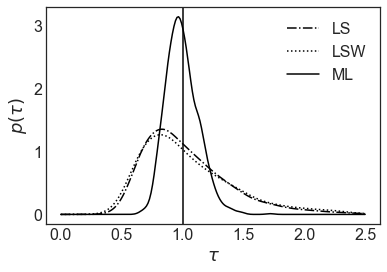

In [9]:
# decay time KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0,2.5,200)
densityLS = gaussian_kde(result_array.T[0])
densityLSW = gaussian_kde(result_array.T[5])
densityML = gaussian_kde(result_Bayes_array.T[2])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.savefig("tau_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/Users/hstrey/miniconda3/envs/pymc3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


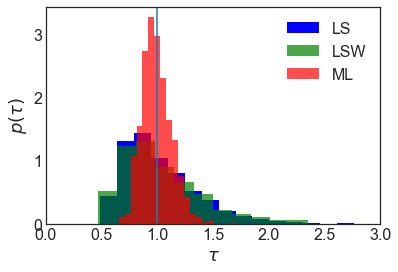

In [10]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[5],normed=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))
plt.savefig("tau_dist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [11]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

phiW = 1/result_array.T[8]
thetaW = 1/result_array.T[6]
omegaW = 1/result_array.T[9]
dAW = np.sqrt(-theta/(phi*theta-omega**2))
dTW = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

In [12]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW mean (real):",result_array.T[5].mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW stderr (real):",result_array.T[5].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[5].mean()-1)/result_array.T[5].std()*np.sqrt(N))
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS mean (real): 1.0511330280624347
Decay time LS std (real): 0.3905818920277206
Decay time LS stderr (real): 0.0039058189202772057
Decay time (mean-true)/stderr: 13.091499914902776
Decay time LS std (fit): 0.016478751794738906
Decay time LS std (fit corrected): 0.01657870257363243
Decay time LSW mean (real): 1.0672294075416684
Decay time LSW std (real): 0.43824080316748193
Decay time LSW stderr (real): 0.004382408031674819
Decay time (mean-true)/stderr: 15.340745785365728
Decay time LSW std (fit): 0.1826576616939671
Decay time LSW std (fit corrected): 0.01657870257363243
Decay time Bayes mean (real): 0.9971927568886603
Decay time Bayes std (real): 0.13307109625094737
Decay time Bayes stderr (real): 0.0013307109625094737
Decay time Bayes std (fit): 0.141744498927101


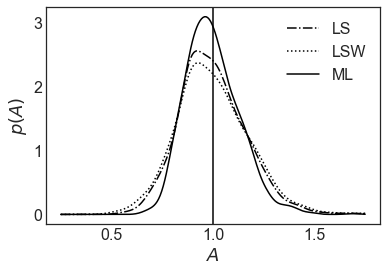

In [13]:
# amplitude KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0.25,1.75,200)
densityLS = gaussian_kde(result_array.T[2])
densityLSW = gaussian_kde(result_array.T[7])
densityML = gaussian_kde(result_Bayes_array.T[0])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")
plt.savefig("A_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

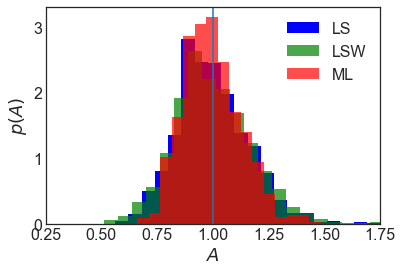

In [14]:
# amplitude
plt.hist(result_array.T[2],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[7],normed=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[0],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))
plt.savefig("A_dist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [15]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW mean (real):",result_array.T[7].mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW stderr (real):",result_array.T[7].std()/np.sqrt(N))
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.9984105682703185
Amplitude LS std (real): 0.16181660243234747
Amplitude LS stderr (real): 0.0016181660243234748
Amplitude LS std (fit): 0.01145025908410378
Amplitude LS std (fit corrected): 0.0113979437567719
Amplitude LSW mean (real): 0.9978750785538824
Amplitude LSW std (real): 0.1759156658804174
Amplitude LSW stderr (real): 0.001759156658804174
Amplitude LSW std (fit): 0.014267847996428617
Amplitude LSW std (fit corrected): 0.0113979437567719
Amplitude Bayes mean (real): 0.9974432559467948
Amplitude Bayes std (real): 0.13182747665608338
Amplitude Bayes std (fit): 0.1410535876226702


(1000, 10)
(1000, 4)
(0.3183106738638477, 5.548446448599749e-25)


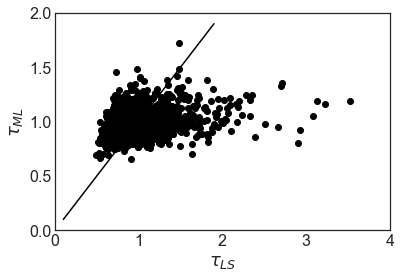

In [16]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(result_array.T[0],result_Bayes_array.T[2],color="k")
plt.plot([0.1,1.9],[0.1,1.9],"k")
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.8370114347767423, 1.3727086902427204e-263)


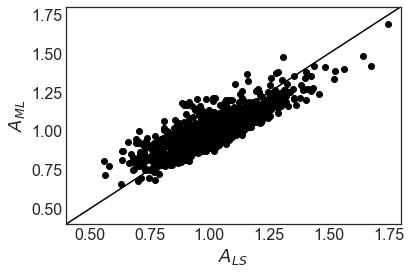

In [17]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0],color="k")
plt.plot([0,1.8],[0,1.8],"k")
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [18]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],dA,result_array.T[0],dT):
    print(i,a,da,t,dt)

0 0.808615696056012 0.00544211158822298 0.9939418654806541 0.009520460345979705
1 0.7384507401780944 0.014800775155431269 1.659481283174133 0.04862577555746138
2 0.8189945390255113 0.008341269650960773 1.2161571144605954 0.017689000724257463
3 1.177426213439023 0.008512380556837134 0.869670623699744 0.008946273247059084
4 1.0437891737470233 0.014007021533873081 0.6674355511975543 0.012763371773673647
5 0.883051617048809 0.00858219052936581 0.7431840677695469 0.010284184173800653
6 0.9986686993248759 0.005205087905933227 0.8289406605407509 0.006148559498558599
7 0.8705609103632095 0.007324202103499727 1.2761723469792459 0.015361640341763991
8 1.0469415961904982 0.004889410637600746 1.0666728821039506 0.0070945098128067305
9 0.8705229773500358 0.005136756260122944 1.404644623697107 0.011921526795272194
10 1.210331143970472 0.021603434174906247 0.6449979054220899 0.01641139632324621
11 1.0678373545348654 0.012159441384276045 1.5898917788383589 0.02633043239929993
12 1.0466327034058365 0.0

654 0.9936219950470155 0.005414179861089583 0.8642170549210936 0.006700783508067425
655 0.9240406108029715 0.00330686558496609 1.045521047963906 0.005327163680617353
656 1.0419611587831445 0.010706304584901134 0.6016159816963211 0.008814440906433869
657 1.3796906367257336 0.02222836263394379 0.701316109097676 0.01609135223724567
658 1.0016502579041822 0.0196156387040846 0.6052074257861851 0.01690327110643452
659 0.8068790536838826 0.01054494900882596 1.209396393375598 0.02256727351677917
660 0.8448943450381698 0.008104959206695895 0.5985731767133358 0.00818731340133432
661 1.425040936832656 0.017156454556700167 0.8211897195886859 0.0140687801472775
662 0.9792009851114964 0.011699141806397096 0.6683429612381256 0.011377033103454235
663 1.1043645708874874 0.010658960854813097 0.815656013010224 0.011202964241582554
664 1.0718439886361044 0.01633558504317089 0.8307712651697817 0.018019844322990988
665 1.0101628959444144 0.009785476078363185 1.1163078044779504 0.015409466846674937
666 0.944

In [19]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))

0.00E+00
-79527971.70080663
0.3989422804014327
2.59E-01
-0.18841818509930627


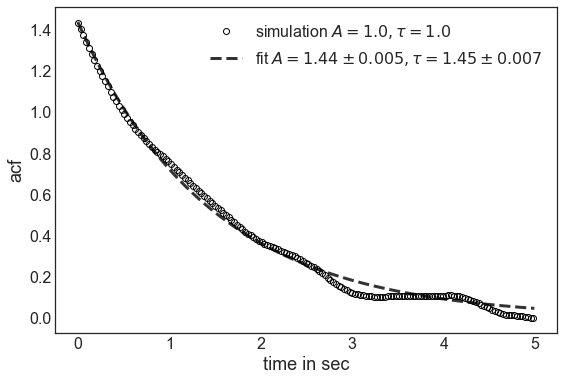

In [20]:
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,"k--",linewidth=3,label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [21]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [22]:
# plot deviation from true D as function of N
Nsim = np.array([2000,10000,50000])
Nsimfit = np.array([1500,10000,60000])
dD = np.array([0.36,0.05,0.014])

(0.005, 1)

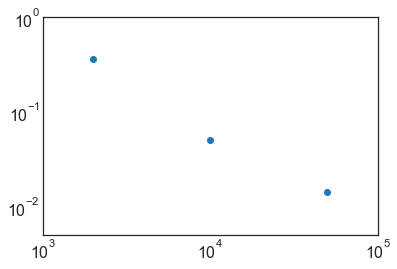

In [23]:
plt.plot(Nsim,dD,"o")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))

In [24]:
lnNsim = np.log(Nsim)
lndD = np.log(dD)

In [25]:
p = np.polyfit(lnNsim,lndD,1)

In [26]:
# dD = A*Nsim**gamma
# ln dD = ln A + gamma*ln Nsim
dDfit = np.exp(p[1])*Nsimfit**p[0]

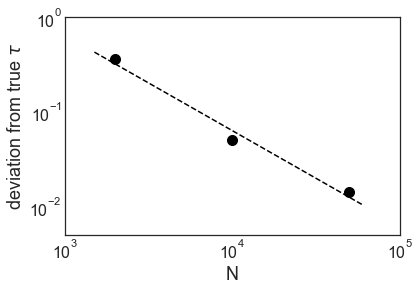

In [27]:
plt.plot(Nsim,dD,"ko",markersize=10)
plt.plot(Nsimfit,dDfit,"k--")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))
plt.xlabel("N")
plt.ylabel(r"deviation from true $\tau$")
plt.savefig("deviation.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [46]:
ext = t[::3]
print(ext.shape)
sigma = np.ones(ext.shape[0])
exa = acf[::3]
with pm.Model() as model:
    A = pm.Uniform('A', lower=0, upper=1000)
    tau = pm.Uniform('tau', lower=0, upper=1000)

    likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-ext/tau),tau=1,observed=exa)
    
    trace = pm.sample(20000,tune=10000)


(167,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1660.73draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c22bb46d8>,
      dtype=object)

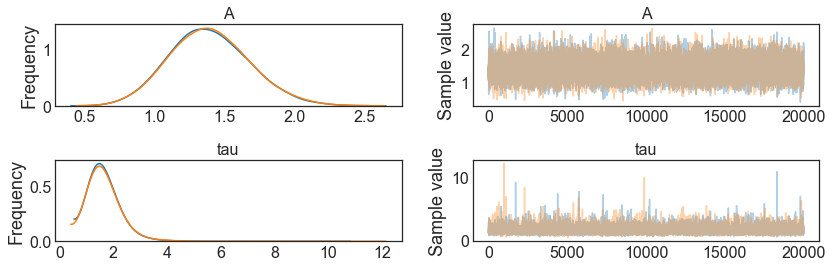

In [47]:
pm.traceplot(trace)

In [50]:
pm.summary(trace)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
A,1.389579,0.285760,0.002764,0.842347,1.956347,11442.463961,1.000037
tau,1.647558,0.572169,0.005810,0.748548,2.709498,10104.521890,1.000042


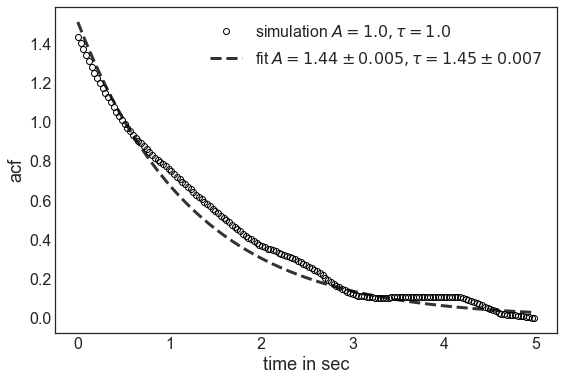

In [39]:
A_mean= trace['A'].mean()
tau_mean=trace['tau'].mean()
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t[::3],trace['A'].mean()*np.exp(-trace['lam'].mean()*t[::3]),"k--",linewidth=3,label=r"fit $A="1.52"\pm0.29,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
#plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")